# Feature Selection

* Keep 욕설
* Delete one letter words (No meaning)
* Delete 생소한 words
* Keep Noun, Adjective, Verb, KoreanParticles
* Information Gain

In [22]:
import pandas as pd
import csv
import os
from collections import defaultdict

In [9]:
allassult = []
with open('./dataset/assult.csv','r',encoding='utf-8') as readfile:
    reader = csv.reader(readfile)
    for row in reader:
        word = False
        for ch in row[0]:
            try:
                ch.encode('ascii')
                word = True
            except:
                pass
        if not word:
            allassult.append(row[0])

In [10]:
with open('./dataset/assult2.csv','w',newline='\n',encoding='utf-8') as writefile:
    writer = csv.writer(writefile)
    for assult in allassult:
        writer.writerow([assult])

## 모든 단어 set 확인 및 욕설 단어 갯수 확인

* 욕 DB에 있는 1439개 단어 중 506개가 사용됨

In [12]:
allword = set()

In [13]:
filepath = './dataset/user_result3/'
files = os.listdir(filepath)
for file in files:
    with open(filepath+file,'r',encoding='utf-8') as readfile:
        reader = csv.reader(readfile)
        for row in reader:
            allword.add(row[0])

In [14]:
len(allword)

233090

In [20]:
assult_set = set(allassult)
len(assult_set)

1439

In [21]:
len(allword & assult_set)

506

---

## 한글자 짜리, 형태소 의미 없는 것들 삭제 + 욕 db에 있으면 남기기

* Noun, Verb, Adjective, KoreanParticle 만 남기기
* 1글자 짜리 삭제

In [81]:
filepath = './dataset/user_result2/'
files = os.listdir(filepath)
all_result = defaultdict(lambda:"")
for file in files:
    with open(filepath+file,'r',encoding='utf-8') as readfile:
        reader = csv.reader(readfile)
        game_id = int(file.split('.')[0])
        for row in reader:
            pos = row[1]
            if row[0] in assult_set:
                for i in range(0,int(row[2])):
                    all_result[game_id]+=(row[0]+" ")
            elif pos in (["Noun","Verb","Adjective","KoreanParticle"]):
                if len(row[0])>1:
                    for i in range(0,int(row[2])):
                        all_result[game_id]+=(row[0]+" ")


라벨링 후 저장

In [82]:
a_list = []
f_list = []
with open('./dataset/cbt5_label.csv','r',encoding='utf-8') as readfile:
    reader = csv.reader(readfile)
    next(reader)
    for row in reader:
        if row[1]=='A':
            a_list.append(int(row[0]))
        else:
            f_list.append(int(row[0]))

In [83]:
allword = set()

In [84]:
with open('./dataset/cbt5_corpus3000.csv','w',newline='\n',encoding='utf-8') as writefile:
    writer = csv.writer(writefile)
    writer.writerow(['game_id','corpus','label'])
    for game_id in all_result.keys():
        if game_id in a_list:
            for w in all_result[game_id].split(' '):
                allword.add(w)
            writer.writerow([game_id,all_result[game_id],'a'])
        elif game_id in f_list:
            writer.writerow([game_id,all_result[game_id],'f'])
            for w in all_result[game_id].split(' '):
                allword.add(w)

In [85]:
len(allword)

41548

# Make Bow

In [44]:
data = pd.read_csv('./dataset/cbt5_corpus.csv')
data.head()

,game_id,corpus,label
0,1001,놓치는 시기 시기 야할 계신 계신 사태 교훈 왕관 오래 오래 오래 오래 회수 회수 ...,a
1,10014,인생 인생 있다 같은 랩때 날틀 날틀 싶은 지랄 지랄 지랄 지랄 쉬발 당연한 열매 ...,f
2,10037,렉쩌는데 문제 추자 춤좀 김정 겜톡 겜톡 겜톡 겜톡 겜톡 안되는 셔플 셔플 셔플 쩐...,f
3,10185,나뭇가지 어렵 제발 몽상 몽상 몽상 사서 상어 상어 구하는 구하는 하다 죽엿는데 죽...,a
4,10230,찾기 ㅇㅋㅇㅋ 나지 어딧는 잠긴 업데이트 파티 좀덜 마우스 마우스 마우스 마우스 개...,f


In [39]:
from sklearn.feature_extraction.text import CountVectorizer

In [114]:
def make_review_bow(data):    
   
    vectorizer = CountVectorizer(min_df=0)

    doc = []
    
    for text in data['corpus']:
        doc.append(text)
    vectorizer.fit(doc)
    x = vectorizer.transform(doc)
    bow2 = x.toarray()
    bow = pd.DataFrame(bow2,columns=vectorizer.vocabulary_.keys())

    return vectorizer, bow

In [74]:
vectorizer, X = make_review_bow(data)

In [76]:
X.head()

,놓치는,시기,야할,계신,사태,교훈,왕관,오래,회수,아쉬운,...,죧망함,하늘가,법니,담업,워주,덴슬로로,치셧어야,명있었꼬,산닷,루틸
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,2,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [77]:
Y = data.label

In [78]:
from sklearn.cross_validation import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import SGDClassifier
from sklearn.naive_bayes import MultinomialNB

x_train, x_test, y_train, y_test = train_test_split(X,Y,test_size=0.3)

In [79]:
sgd = SGDClassifier()
sgd.fit(x_train, y_train)
print ("Model Accuracy:", 100 * sgd.score(x_test, y_test))

Model Accuracy: 93.6102236422


In [80]:
nb = MultinomialNB()
nb.fit(x_train, y_train)
print ("Model Accuracy:", 100 * nb.score(x_test, y_test))

Model Accuracy: 57.1884984026


---

# using first 3000 words

In [87]:
data = pd.read_csv('./dataset/cbt5_corpus3000label.csv')
data.head()

,game_id,corpus,label
0,1001,교훈 시기 시기 계신 계신 사태 놓치는 오래 오래 오래 오래 이상 아쉬운 해주시 사...,a
1,10014,인생 인생 만세 있다 같은 랩때 날틀 날틀 싶은 지랄 지랄 지랄 지랄 쉬발 먹엇어 ...,f
2,10037,문제 추자 춤좀 겜톡 겜톡 겜톡 겜톡 겜톡 안되는 셔플 셔플 셔플 쩐다 맨손 마리 ...,f
3,10185,하셧 가기 계신 보고 싶은 짜증 짜증 약간 육식 육식 육식 육식 육식 육식 육식 육...,a
4,10230,찾기 ㅇㅋㅇㅋ 나지 개사 잡으 여기 여기 여기 여기 여기 잠긴 업데이트 파티 좀덜 ...,f


In [115]:
vectorizer, X = make_review_bow(data)
Y = data.label
x_train, x_test, y_train, y_test = train_test_split(X,Y,test_size=0.3)

In [89]:
sgd = SGDClassifier()
sgd.fit(x_train, y_train)
print ("Model Accuracy:", 100 * sgd.score(x_test, y_test))

Model Accuracy: 96.1661341853


In [90]:
nb = MultinomialNB()
nb.fit(x_train, y_train)
print ("Model Accuracy:", 100 * nb.score(x_test, y_test))

Model Accuracy: 91.054313099


In [116]:
X.head()

,교훈,시기,계신,사태,놓치는,오래,이상,아쉬운,해주시,사이좋,...,수익금,ㅣㅓ,은괴듬,빠빠밤,명있었꼬,나다물량,ㅇㄹㄴㅇㄹ,선창,리익,ㅜㄴㅁㅇㄹ
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0


---
# Information Gain

In [99]:
from sklearn.feature_selection import mutual_info_classif
import operator

In [96]:
res = dict(zip(X.columns, mutual_info_classif(x_train, y_train, discrete_features=True)))

In [97]:
res

{'교훈': 0.047513502736935984,
 '시기': 0.00089390056702486585,
 '계신': 0.00089390056702486585,
 '사태': 0.00089390056702486585,
 '놓치는': 0.0010149032971999445,
 '오래': 0.0015215607364247466,
 '이상': 0.0010149032971999445,
 '아쉬운': 0.00089390056702486585,
 '해주시': 0.0010149032971999445,
 '사이좋': 0.014571768964357589,
 '습득': 0.0010149032971999445,
 '해주셔': 0.0035860396713805164,
 '평결': 0.0010149032971999445,
 '걸려': 4.4408920985006262e-16,
 '지금': 0.0010149032971999445,
 '고치': 0.0010149032971999445,
 '준비하러': 0.0010149032971999445,
 '여러': 0.0010149032971999445,
 '오시': 4.4408920985006262e-16,
 'ㅊㅋㅊㅋ': 0.0010149032971999445,
 '즐기': 0.00089390056702486585,
 '관계': 0.0010149032971999445,
 '있는': 0.00060044626671689263,
 '있어': 4.4408920985006262e-16,
 '얼마나': 0.0010149032971999445,
 '마음씨': 0.0010149032971999445,
 '뭔가': 0.0010149032971999445,
 '다른사람': 0.0020318757319242077,
 '아니': 0.0010149032971999445,
 '간혹': 2.6639227801994458e-06,
 '딛히': 0.00089390056702486585,
 '드릴': 4.4408920985006262e-16,
 '마네킹': 0.0010149

In [104]:
sorted_x = sorted(res.items(), key=operator.itemgetter(1),reverse=False)

In [105]:
sorted_x

[('걸려', 4.4408920985006262e-16),
 ('오시', 4.4408920985006262e-16),
 ('있어', 4.4408920985006262e-16),
 ('드릴', 4.4408920985006262e-16),
 ('다리', 4.4408920985006262e-16),
 ('이용하지', 4.4408920985006262e-16),
 ('이야기해', 4.4408920985006262e-16),
 ('이번', 4.4408920985006262e-16),
 ('지치', 4.4408920985006262e-16),
 ('사안', 4.4408920985006262e-16),
 ('디버프', 4.4408920985006262e-16),
 ('독하다', 4.4408920985006262e-16),
 ('변호인', 4.4408920985006262e-16),
 ('색깔', 4.4408920985006262e-16),
 ('여러분', 4.4408920985006262e-16),
 ('래야', 4.4408920985006262e-16),
 ('같아', 4.4408920985006262e-16),
 ('기준', 4.4408920985006262e-16),
 ('있었', 4.4408920985006262e-16),
 ('얻어', 4.4408920985006262e-16),
 ('같구', 4.4408920985006262e-16),
 ('시간', 4.4408920985006262e-16),
 ('타실', 4.4408920985006262e-16),
 ('보물상자', 4.4408920985006262e-16),
 ('부분', 4.4408920985006262e-16),
 ('아쉬워', 4.4408920985006262e-16),
 ('같은', 4.4408920985006262e-16),
 ('열렙했어', 4.4408920985006262e-16),
 ('서요', 4.4408920985006262e-16),
 ('진행됩', 4.4408920985006262e-1

---

# 욕설 카운트

In [106]:
len(allassult)

1480

In [108]:
with open('./dataset/cbt5_corpus3000label.csv','r',encoding='utf-8') as readfile:
    reader = csv.reader(readfile)
    next(reader)
#     writer.writerow(['game_id','corpus','label'])
    with open('./dataset/cbt5_assultstat.csv','w',newline='\n') as writefile:
        writer = csv.writer(writefile)
        writer.writerow(['game_id','label','count'])
        for row in reader:
            words = row[1].split(' ')
            count = 0
            for word in words:
                if word in allassult:
                    count+=1
            writer.writerow([row[0],row[2],count])

In [118]:
assult_data = pd.read_csv('./dataset/cbt5_assultstat.csv')
assult_data.head()

,game_id,label,count
0,1001,a,3
1,10014,f,7
2,10037,f,8
3,10185,a,1
4,10230,f,4


In [120]:
data_a = assult_data.loc[assult_data.label=='a']
data_f = assult_data.loc[assult_data.label=='f']

In [121]:
import matplotlib.pyplot as plt

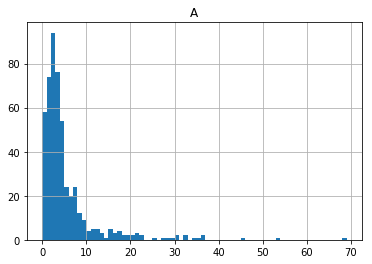

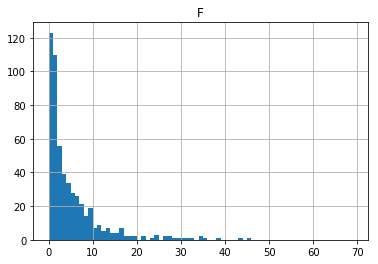

In [131]:

data_a['count'].hist(bins=range(0,70,1))
plt.title("A")
plt.show()

data_f['count'].hist(bins=range(0,70,1))
plt.title("F")
plt.show()